# Recurrent Neural Networks (RNNs) and LSTMs in PyTorch

## 1. Introduction

In this tutorial, we will introduce the fundamental concepts behind **Recurrent Neural Networks (RNNs)** and then focus on the **Long Short-Term Memory (LSTM)** architecture.

Recurrent neural networks are specifically designed to handle sequential data, such as time series or natural language, by maintaining a hidden state that captures information from past inputs. However, vanilla RNNs can suffer from vanishing or exploding gradients when dealing with long sequences. The LSTM architecture addresses this challenge by introducing a cell state and gating mechanisms (input, forget, and output gates), enabling the network to better capture long-term dependencies.

This tutorial is divided into two main parts:
1. **Simulation-based example**: We'll generate a simple time series (sine wave with noise) and train an LSTM to predict future values.
2. **Empirical data example**: We'll use the classic "Airline Passengers" dataset and apply an LSTM-based approach. In the empirical example, we enhance the LSTM architecture to better capture seasonality.

By the end of this notebook, you will:
- Understand how RNNs and LSTMs work in PyTorch.
- Know how to build and train your own LSTM model for time series forecasting.
- Be able to apply these techniques to both simulated and empirical data.

## 2. Installation and Imports

First, we'll import the necessary libraries. We will rely on:
- **PyTorch** for building neural networks.
- **NumPy** and **pandas** for data manipulation.
- **matplotlib** for plotting.

Make sure you have PyTorch installed. If not, install with `pip install torch` or check the PyTorch website for instructions.

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Make plots inline for Jupyter
%matplotlib inline

# Check PyTorch version and device
print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.2.1+cu121
Using device: cpu


## 3. Brief Recap: RNNs and LSTMs

### 3.1 The Recurrent Neural Network (RNN)

An RNN processes sequences one step at a time, updating a hidden state \( h_t \) that depends on both the input at the current time step \( x_t \) and the previous hidden state \( h_{t-1} \). Mathematically:

\[
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
\]

where:
- \( h_t \) is the hidden state at time \( t \).
- \( x_t \) is the input at time \( t \).
- \( W_{hh} \) and \( W_{xh} \) are weight matrices.
- \( b_h \) is a bias term.

### 3.2 The LSTM Cell

An LSTM improves upon the vanilla RNN by introducing:
- A **cell state** \( C_t \) that can carry information across many time steps.
- Three gates:
  1. **Forget gate** \( f_t \)
  2. **Input gate** \( i_t \)
  3. **Output gate** \( o_t \)

At each time step, the LSTM cell updates the cell state \( C_t \) and the hidden state \( h_t \) using:

\[
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \\
h_t &= o_t * \tanh(C_t)
\end{aligned}
\]

Here:
- \( \sigma \) denotes the sigmoid function.
- \( \tanh \) is the hyperbolic tangent function.
- \( W_f, W_i, W_C, W_o \) and \( b_f, b_i, b_C, b_o \) are learned parameters.

This design helps the network maintain **long-term dependencies** by controlling how much information flows into and out of the cell state.

## 4. Building a Time Series Forecaster with LSTM

In this section, we will create a synthetic time series and attempt to predict future values using an LSTM. We'll simulate a noisy sine wave.

### 4.1 Generating the Data

Let's generate a sine wave with added Gaussian noise. Then we'll:
1. Prepare the data into sequences suitable for an LSTM.
2. Split the data into training and test sets.

We will use a **window (sequence) length** hyperparameter `seq_length`. For each sequence, we want to predict the **next value**.

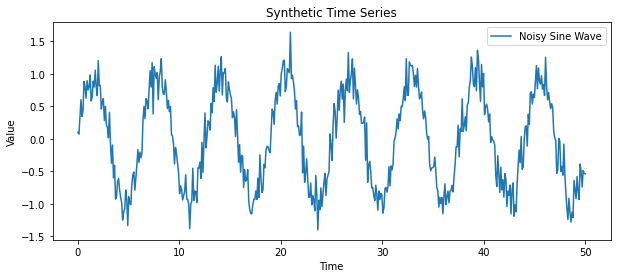

In [2]:
# Data Generation

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for our synthetic time series
N = 500              # total number of points
time_steps = np.linspace(0, 50, N)  # generate time steps
data = np.sin(time_steps) + 0.2 * np.random.randn(N)  # sine wave + noise

plt.figure(figsize=(10, 4))
plt.plot(time_steps, data, label='Noisy Sine Wave')
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

### 4.2 Preparing Sequences for LSTM

PyTorch's LSTM expects data typically in the form:

\( (\text{batch_size}, \text{sequence_length}, \text{features}) \)

- **`features`** here would be 1 if we only have a univariate time series.

We will write a helper function `create_sequences` that transforms the 1D time series into a set of (sequence, target) pairs:
1. Each sequence is a sliding window of length `seq_length`.
2. The target is the value immediately following the sequence.

In [3]:
# Data Preprocessing

def create_sequences(dataset, seq_length):
    """
    dataset: array-like of shape (N,)
    seq_length: int, length of the sliding window
    
    Returns:
        X: numpy array of shape (number_of_sequences, seq_length)
        y: numpy array of shape (number_of_sequences,)
    """
    X = []
    y = []
    for i in range(len(dataset) - seq_length):
        # Extract sequence of length seq_length
        seq = dataset[i : i + seq_length]
        # The target is the next value after the sequence
        target = dataset[i + seq_length]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# We will use a window size
seq_length = 20

X, y = create_sequences(data, seq_length)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Shape of X: (480, 20)
Shape of y: (480,)
Training set size: 384
Test set size: 96


### 4.3 Converting Data to PyTorch Tensors

We'll need to convert our NumPy arrays to **PyTorch tensors** and reshape them to the format `(batch_size, sequence_length, number_of_features)`. 

- Since our time series is univariate, `number_of_features = 1`.

In [4]:
# Create Torch Datasets

# Convert to PyTorch tensors
X_train_tensors = torch.from_numpy(X_train).float()
y_train_tensors = torch.from_numpy(y_train).float()

X_test_tensors = torch.from_numpy(X_test).float()
y_test_tensors = torch.from_numpy(y_test).float()

# Reshape to (batch_size, seq_length, 1)
X_train_tensors = X_train_tensors.unsqueeze(-1)  # shape: (train_size, seq_length, 1)
X_test_tensors  = X_test_tensors.unsqueeze(-1)   # shape: (test_size, seq_length, 1)

print("X_train_tensors shape:", X_train_tensors.shape)
print("y_train_tensors shape:", y_train_tensors.shape)

X_train_tensors shape: torch.Size([384, 20, 1])
y_train_tensors shape: torch.Size([384])


### Data Splitting, Minibatching, and Shuffling for Sequence Data

After creating the sequences using the sliding window approach, each sequence (of length `seq_length`) along with its corresponding target value is treated as an independent sample. However, note that these samples originate from a single continuous time series, so their ordering is inherently temporal.

#### Splitting the Data

To mimic a real-world forecasting scenario, we split the data in a temporal fashion. That is, the first 80% of the sequences are used for training and the remaining 20% for testing. This ensures that the model is trained solely on past data and tested on future data, avoiding look-ahead bias.

#### Minibatching

Neural networks are often trained on mini-batches rather than the full dataset to obtain more stable gradient estimates and efficiently utilize GPU resources. In our notebook, we directly convert the entire training set to PyTorch tensors. If you wish to use mini-batches, you can wrap these tensors into a `torch.utils.data.TensorDataset` and then use a `DataLoader` with a specified `batch_size`.

#### Shuffling

For many machine learning tasks, shuffling the training data is important to break any inherent order and improve generalization. However, in time series forecasting, preserving the temporal order is crucial. In our case, since each sequence is a contiguous segment from the time series, shuffling the individual samples (if done via a DataLoader) does not disturb the order within each sequence, but it does break the overall temporal continuity. Thus, many practitioners choose not to shuffle the training data for forecasting tasks.

In this notebook, we split the data sequentially and do not apply additional shuffling. This preserves the time order, which is appropriate for forecasting.

### 4.4 Defining the LSTM Model

We will create a small LSTM-based regressor. The steps are:
1. Use `nn.LSTM` with some hidden dimension (`hidden_size`).
2. Take the final hidden state (or the final output) to produce a single forecast (`nn.Linear` from hidden dimension to 1).

**Important Model Parameters**:
- `input_size`: 1 (univariate time series)
- `hidden_size`: number of LSTM units (hyperparameter)
- `num_layers`: how many stacked LSTM layers (common to start with 1 or 2)
- `output_size`: 1 (predicting a single future value)

In [5]:
# LSTM Model Definition

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1, dropout=0.0):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # If using more than 1 layer, enable dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Take only the last output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

### 4.5 Model Instantiation and Training

We'll define:
1. Model hyperparameters (`hidden_size`, etc.).
2. Loss function (MSE is standard for regression).
3. Optimizer (Adam is commonly used).
4. The training loop.

#### Important Aspects to Tune / Explore

- **`hidden_size`**: The dimensionality of the LSTM hidden state. Larger values can capture more complexity but are slower to train and may overfit.
- **Number of epochs**: Too few might underfit; too many might overfit.
- **Learning rate**: A small learning rate might converge slowly; a large one might diverge.

We'll keep things simple for the synthetic example.

In [6]:
# Training the LSTM on Synthetic Data

# Hyperparameters for synthetic data
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 100

# Create model instance
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size).to(device)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Ensure data is on the same device
X_train_tensors = X_train_tensors.to(device)
y_train_tensors = y_train_tensors.to(device)
X_test_tensors  = X_test_tensors.to(device)
y_test_tensors  = y_test_tensors.to(device)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_train_pred = model(X_train_tensors)
    loss = criterion(y_train_pred.squeeze(), y_train_tensors)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensors)
        test_loss = criterion(y_test_pred.squeeze(), y_test_tensors)
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch [10/100], Train Loss: 0.4564, Test Loss: 0.4077
Epoch [20/100], Train Loss: 0.3981, Test Loss: 0.3578
Epoch [30/100], Train Loss: 0.3208, Test Loss: 0.2836
Epoch [40/100], Train Loss: 0.2194, Test Loss: 0.1885
Epoch [50/100], Train Loss: 0.1721, Test Loss: 0.1738
Epoch [60/100], Train Loss: 0.1193, Test Loss: 0.1098
Epoch [70/100], Train Loss: 0.0722, Test Loss: 0.0738
Epoch [80/100], Train Loss: 0.0527, Test Loss: 0.0731
Epoch [90/100], Train Loss: 0.0483, Test Loss: 0.0620
Epoch [100/100], Train Loss: 0.0487, Test Loss: 0.0615


### 4.6 Analyzing Results on Synthetic Data

Let's first plot the loss curves and then compare the predictions on the test set.

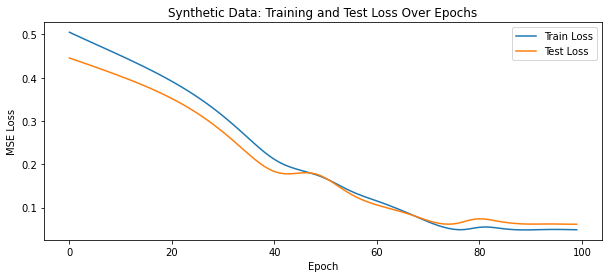

In [7]:
# Plot Losses for Synthetic Data
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Synthetic Data: Training and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

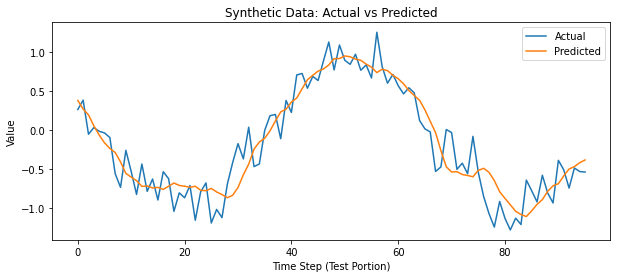

In [8]:
# Predictions on Synthetic Test Set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensors).cpu().numpy()

actual = y_test_tensors.cpu().numpy()

plt.figure(figsize=(10, 4))
plt.plot(range(len(actual)), actual, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')
plt.title("Synthetic Data: Actual vs Predicted")
plt.xlabel("Time Step (Test Portion)")
plt.ylabel("Value")
plt.legend()
plt.show()

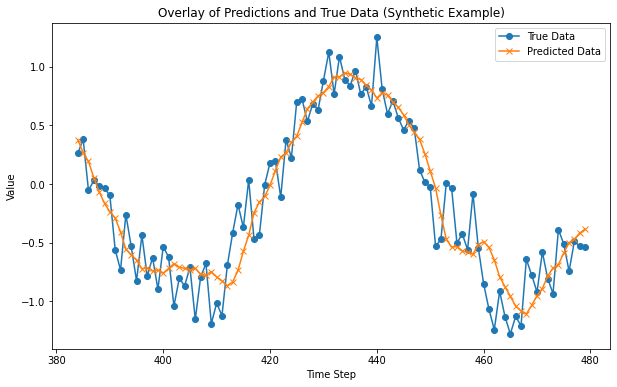

In [9]:
# Overlay Plot for Synthetic Data
# Create a time index for the test set based on the original sliding window split
time_test = np.arange(train_size, train_size + len(y_test))

plt.figure(figsize=(10,6))
plt.plot(time_test, y_test, label='True Data', marker='o')
plt.plot(time_test, predictions, label='Predicted Data', marker='x')
plt.title("Overlay of Predictions and True Data (Synthetic Example)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

---
## 5. Empirical Time Series Example: Airline Passengers Dataset

In this section, we use the classic "Airline Passengers" dataset. This dataset contains monthly totals of international airline passengers from 1949 to 1960. We will:
1. Download the dataset from a public URL.
2. Focus on the `Passengers` column as our time series.
3. Normalize the data and create sequences for the LSTM.

In [10]:
# Download the Airline Passengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df_passengers = pd.read_csv(url, parse_dates=["Month"], index_col="Month")
print("Airline Passengers Data (first 5 rows):")
print(df_passengers.head())

Airline Passengers Data (first 5 rows):
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


### 5.2 Data Visualization and Preprocessing

We'll visualize the number of passengers over time, then normalize the `Passengers` column using Min-Max scaling. Finally, we create sequences for the LSTM.

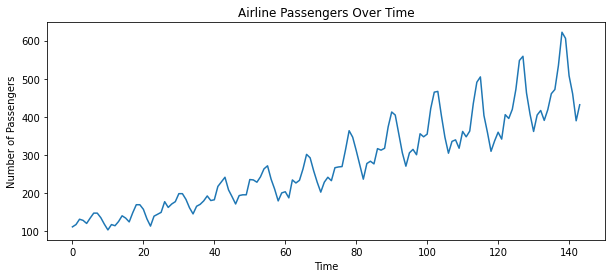

Min passengers: 104, Max passengers: 622


In [11]:
# Plot and Scale

if df_passengers.empty:
    raise ValueError("The downloaded Airline Passengers DataFrame is empty. Please check the URL.")

passengers = df_passengers['Passengers'].values

if passengers.size == 0:
    raise ValueError("The passengers array is empty. No data found.")

plt.figure(figsize=(10,4))
plt.plot(passengers)
plt.title("Airline Passengers Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.show()

min_pass = np.min(passengers)
max_pass = np.max(passengers)
passengers_scaled = (passengers - min_pass) / (max_pass - min_pass)

print(f"Min passengers: {min_pass}, Max passengers: {max_pass}")

#### 5.2.1 Sequence Preparation

We create sequences from the scaled data using a 12-month window.

In [12]:
# Create Sequences from Passengers Data

seq_length = 6  # Using a 12-month window
X_pass, y_pass = create_sequences(passengers_scaled, seq_length)

print("Shape of X_pass:", X_pass.shape)
print("Shape of y_pass:", y_pass.shape)

train_size = int(0.8 * len(X_pass))
X_train_pass, X_test_pass = X_pass[:train_size], X_pass[train_size:]
y_train_pass, y_test_pass = y_pass[:train_size], y_pass[train_size:]

print("Train set size (passengers):", len(X_train_pass))
print("Test set size (passengers):", len(X_test_pass))

# Convert to tensors
X_train_pass_tensors = torch.from_numpy(X_train_pass).float().unsqueeze(-1).to(device)
y_train_pass_tensors = torch.from_numpy(y_train_pass).float().to(device)

X_test_pass_tensors = torch.from_numpy(X_test_pass).float().unsqueeze(-1).to(device)
y_test_pass_tensors = torch.from_numpy(y_test_pass).float().to(device)

Shape of X_pass: (138, 6)
Shape of y_pass: (138,)
Train set size (passengers): 110
Test set size (passengers): 28


### 5.3 Building and Training the LSTM Model on Passengers Data (Improved)

The initial model struggled to capture the seasonality in the data. In this improved version, we enhance the model by:

- Increasing the hidden size to 128.
- Using 3 LSTM layers.
- Applying dropout (0.2) to help prevent overfitting and capture seasonal patterns better.
- Training for 200 epochs.

Below is the improved model training cell for the Airline Passengers dataset.

In [13]:
# Model for Airline Passengers Data - Improved

# Use improved hyperparameters: increased hidden size, more layers, and dropout
model_pass_improved = LSTMRegressor(input_size=1, hidden_size=128, num_layers=3, output_size=1, dropout=0.2).to(device)

criterion_pass_improved = nn.MSELoss()
optimizer_pass_improved = optim.Adam(model_pass_improved.parameters(), lr=0.001)

num_epochs_pass_improved = 200

train_losses_pass_improved = []
test_losses_pass_improved = []

for epoch in range(num_epochs_pass_improved):
    model_pass_improved.train()
    optimizer_pass_improved.zero_grad()
    
    y_train_pred_pass_improved = model_pass_improved(X_train_pass_tensors)
    loss_pass_improved = criterion_pass_improved(y_train_pred_pass_improved.squeeze(), y_train_pass_tensors)
    
    loss_pass_improved.backward()
    optimizer_pass_improved.step()
    
    model_pass_improved.eval()
    with torch.no_grad():
        y_test_pred_pass_improved = model_pass_improved(X_test_pass_tensors)
        test_loss_pass_improved = criterion_pass_improved(y_test_pred_pass_improved.squeeze(), y_test_pass_tensors)
    
    train_losses_pass_improved.append(loss_pass_improved.item())
    test_losses_pass_improved.append(test_loss_pass_improved.item())
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_pass_improved}], Train Loss: {loss_pass_improved.item():.6f}, Test Loss: {test_loss_pass_improved.item():.6f}")

Epoch [20/200], Train Loss: 0.032611, Test Loss: 0.181493
Epoch [40/200], Train Loss: 0.023826, Test Loss: 0.102890
Epoch [60/200], Train Loss: 0.010915, Test Loss: 0.035499
Epoch [80/200], Train Loss: 0.008495, Test Loss: 0.030890
Epoch [100/200], Train Loss: 0.009097, Test Loss: 0.031905
Epoch [120/200], Train Loss: 0.008454, Test Loss: 0.030046
Epoch [140/200], Train Loss: 0.008433, Test Loss: 0.027678
Epoch [160/200], Train Loss: 0.006946, Test Loss: 0.023556
Epoch [180/200], Train Loss: 0.006925, Test Loss: 0.019144
Epoch [200/200], Train Loss: 0.006345, Test Loss: 0.016058


### 5.4 Evaluate the Performance on Passengers Data (Improved)

We'll plot the loss curves and compare the predicted number of passengers to the actual values. Note that the predictions are on scaled data; we convert them back to original values.

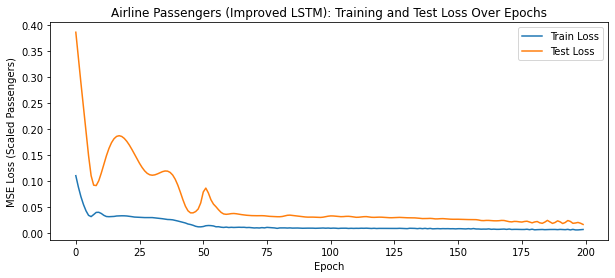

In [14]:
# Plot Losses - Improved Passengers Data
plt.figure(figsize=(10,4))
plt.plot(train_losses_pass_improved, label='Train Loss')
plt.plot(test_losses_pass_improved, label='Test Loss')
plt.title("Airline Passengers (Improved LSTM): Training and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Scaled Passengers)")
plt.legend()
plt.show()

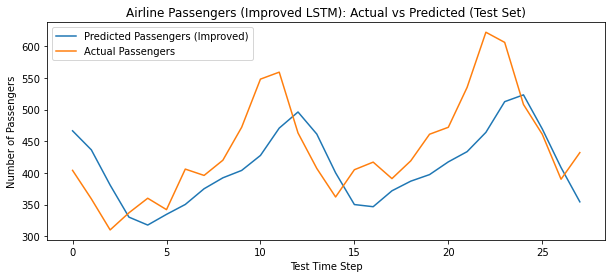

In [15]:
# Predictions and Plot - Improved Passengers Data
model_pass_improved.eval()
with torch.no_grad():
    preds_pass_improved = model_pass_improved(X_test_pass_tensors).cpu().numpy().squeeze()

# Convert from scaled values back to original passenger numbers
preds_pass_improved_unscaled = preds_pass_improved * (max_pass - min_pass) + min_pass
actual_pass_unscaled = y_test_pass_tensors.cpu().numpy() * (max_pass - min_pass) + min_pass

plt.figure(figsize=(10,4))
plt.plot(preds_pass_improved_unscaled, label='Predicted Passengers (Improved)')
plt.plot(actual_pass_unscaled, label='Actual Passengers')
plt.title("Airline Passengers (Improved LSTM): Actual vs Predicted (Test Set)")
plt.xlabel("Test Time Step")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

If the model has learned well, the improved LSTM predictions should now capture the seasonal pattern much better.
---

## 6. Choosing and Tuning LSTM Architectures

When building LSTM networks for time series forecasting, consider:

1. **Sequence length (`seq_length`)**: 
   - A short window might not capture enough history.
   - A very long window might cause training difficulties or overfit.

2. **Hidden size (`hidden_size`)**:
   - Larger hidden_size can capture more complex patterns, but increases computation time.
   - Typically, values range from 32 to a few hundred.

3. **Number of layers (`num_layers`)**:
   - Stacking multiple LSTM layers can capture more abstractions, but also might lead to overfitting if data is limited.
   - Often 1-3 layers are common in practice.

4. **Regularization**:
   - LSTMs can overfit. Consider using dropout (`nn.LSTM(..., dropout=...)`) or weight decay in the optimizer.

5. **Learning rate**:
   - Start with 0.001 or 0.0001 and adjust.

6. **Number of epochs**:
   - Monitor validation (test) loss to avoid overfitting. If test loss stops improving, consider early stopping.

7. **Scaling**:
   - Scaling or normalization often helps training. MinMax, StandardScaler, or robust scalers are popular.

Remember: The best architecture often requires **iterative experimentation** and can depend heavily on the nature of the time series.

## 7. Conclusion and Further Steps

In this tutorial, we:
1. Built a synthetic time series (noisy sine wave) and trained an LSTM to predict future values.
2. Demonstrated a similar workflow on the Airline Passengers dataset, and improved the LSTM architecture to better capture seasonality.
3. Discussed how to choose and tune hyperparameters for LSTM forecasting.

**Suggested next steps**:
- Experiment with different sequence lengths.
- Try different numbers of LSTM layers or hidden sizes.
- Include additional features (e.g., time of year, lagged variables) for forecasting.
- Explore advanced architectures like GRUs or Transformers for time series forecasting.

**Key takeaway**: PyTorch makes it straightforward to implement LSTMs. Mastering time series forecasting requires both neural network skills and a deep understanding of your data's domain characteristics.

*End of Notebook*